# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

#helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

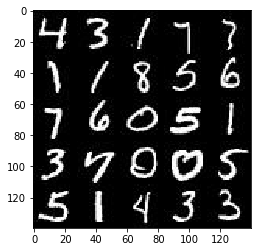

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

In [3]:
import os
from glob import glob
from matplotlib import pyplot

show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    learning_rate = tf.placeholder(tf.float32,None,name="learning_rate")
    real = tf.placeholder(tf.float32,(None,image_width, image_height, image_channels),name="real_image")
    fake = tf.placeholder(tf.float32,(None,z_dim),name="fake_image")
    return (real,fake,learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator',reuse=reuse):
        #input is 28*28*3
        
        #first layer
        h1 = tf.layers.conv2d(images,64,5,strides=2,padding='same')
        h1 = tf.maximum(0.2 * h1, h1)
        #14*14*64
        
        #second layer
        h2 = tf.layers.conv2d(h1,128,5,strides=2,padding='same')
        h2 = tf.layers.batch_normalization(h2, training=True)
        h2 = tf.maximum(0.2 * h2, h2)
        #7*7*128
        
        #third layer
        h3 = tf.layers.conv2d(h2,256,5,strides=2,padding='same')
        h3 = tf.layers.batch_normalization(h3, training=True)
        h3 = tf.maximum(0.2 * h3, h3)
        #4*4*256
        
        
        #output layer
        out = tf.reshape(h3, (-1, 4*4*256))
        logits = tf.layers.dense(out,1)
        out = tf.sigmoid(logits)
        
        
    return out,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator',reuse = not is_train):

        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7,7, 512))
        x1 = tf.maximum(0.2 * x1, x1)
        #7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        #14*14*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        #28*28*128
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def cross_entropy(logits,labels):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=labels))

def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_out = generator(input_z, out_channel_dim)
    d_out_real,d_logits_real = discriminator(input_real)
    d_out_fake,d_logits_fake = discriminator(g_out,reuse=True)
    
    d_real_loss = cross_entropy(d_logits_real,tf.ones_like(d_logits_real)*0.9) #smoothing positive labels with 0.9
    d_fake_loss = cross_entropy(d_logits_fake,tf.zeros_like(d_logits_fake))
    
    g_loss = cross_entropy(d_logits_fake,tf.ones_like(d_logits_fake))
    
    return d_real_loss+d_fake_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    all_vars = tf.trainable_variables()
    g_vars = [var for var in all_vars if var.name.startswith('generator')]
    d_vars = [var for var in all_vars if var.name.startswith('discriminator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):  
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    height  =  data_shape[1]
    width   =  data_shape[2]
    out_dim =  data_shape[3]

    input_real,input_z,learning = model_inputs(height, width, out_dim, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, out_dim)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning, beta1)
    
    g_out = generator(input_z, out_dim, is_train=False)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            step=0
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2 #since batch images are in (-0.5,0.5)
                step+=1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                _ = sess.run(d_train_opt,feed_dict={input_real:batch_images, input_z: batch_z,learning:learning_rate})
                _ = sess.run(g_train_opt,feed_dict={input_real:batch_images,input_z: batch_z,learning:learning_rate})
                _ = sess.run(g_train_opt,feed_dict={input_real:batch_images,input_z: batch_z,learning:learning_rate})
                
                if step%10==0:
                    train_loss_d = sess.run(d_loss,feed_dict={input_real:batch_images, input_z: batch_z})
                    train_loss_g = sess.run(g_loss,feed_dict={input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),"Discriminator Loss: {:.4f}...".format(train_loss_d),
                  "Generator Loss: {:.4f}".format(train_loss_g))
                if step%100==0:
                    show_generator_output(sess, 1, input_z, out_dim, data_image_mode)
                   
            
            
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.0930... Generator Loss: 17.5292
Epoch 1/2... Discriminator Loss: 1.4959... Generator Loss: 3.0576
Epoch 1/2... Discriminator Loss: 3.1328... Generator Loss: 1.2590
Epoch 1/2... Discriminator Loss: 2.0388... Generator Loss: 0.6301
Epoch 1/2... Discriminator Loss: 2.2391... Generator Loss: 1.1563
Epoch 1/2... Discriminator Loss: 1.8113... Generator Loss: 1.0966
Epoch 1/2... Discriminator Loss: 1.8109... Generator Loss: 0.9648
Epoch 1/2... Discriminator Loss: 1.6904... Generator Loss: 0.7868
Epoch 1/2... Discriminator Loss: 1.5928... Generator Loss: 0.6667
Epoch 1/2... Discriminator Loss: 1.6548... Generator Loss: 1.0483


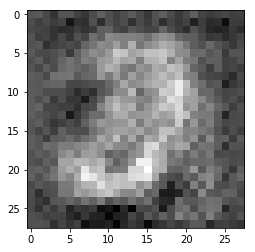

Epoch 1/2... Discriminator Loss: 1.4607... Generator Loss: 0.7607
Epoch 1/2... Discriminator Loss: 1.4797... Generator Loss: 0.7860
Epoch 1/2... Discriminator Loss: 1.5853... Generator Loss: 1.0237
Epoch 1/2... Discriminator Loss: 1.4283... Generator Loss: 1.2234
Epoch 1/2... Discriminator Loss: 1.4942... Generator Loss: 1.0184
Epoch 1/2... Discriminator Loss: 1.5348... Generator Loss: 0.9645
Epoch 1/2... Discriminator Loss: 1.5378... Generator Loss: 0.8638
Epoch 1/2... Discriminator Loss: 1.6082... Generator Loss: 1.0750
Epoch 1/2... Discriminator Loss: 1.4844... Generator Loss: 0.9024
Epoch 1/2... Discriminator Loss: 1.4629... Generator Loss: 0.7975


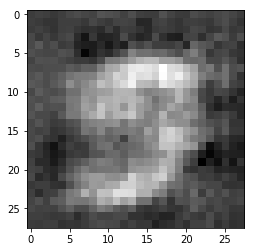

Epoch 1/2... Discriminator Loss: 1.5615... Generator Loss: 0.4551
Epoch 1/2... Discriminator Loss: 1.7417... Generator Loss: 0.3125
Epoch 1/2... Discriminator Loss: 1.5341... Generator Loss: 0.5789
Epoch 1/2... Discriminator Loss: 1.7142... Generator Loss: 0.3554
Epoch 1/2... Discriminator Loss: 1.7300... Generator Loss: 0.3531
Epoch 1/2... Discriminator Loss: 1.5204... Generator Loss: 0.5192
Epoch 1/2... Discriminator Loss: 1.8304... Generator Loss: 0.2849
Epoch 1/2... Discriminator Loss: 1.5366... Generator Loss: 0.4803
Epoch 1/2... Discriminator Loss: 1.7293... Generator Loss: 0.3765
Epoch 1/2... Discriminator Loss: 1.7290... Generator Loss: 0.3348


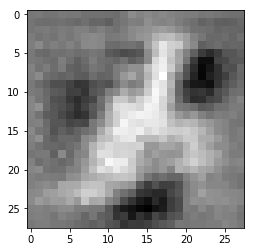

Epoch 1/2... Discriminator Loss: 1.5409... Generator Loss: 0.4627
Epoch 1/2... Discriminator Loss: 1.7201... Generator Loss: 0.3768
Epoch 1/2... Discriminator Loss: 1.6500... Generator Loss: 0.4212
Epoch 1/2... Discriminator Loss: 1.5495... Generator Loss: 0.5183
Epoch 1/2... Discriminator Loss: 1.7591... Generator Loss: 0.3140
Epoch 1/2... Discriminator Loss: 1.5657... Generator Loss: 0.4650
Epoch 1/2... Discriminator Loss: 1.7406... Generator Loss: 0.3395
Epoch 1/2... Discriminator Loss: 1.4521... Generator Loss: 0.5627
Epoch 1/2... Discriminator Loss: 1.5208... Generator Loss: 0.7259
Epoch 1/2... Discriminator Loss: 1.5630... Generator Loss: 0.9898


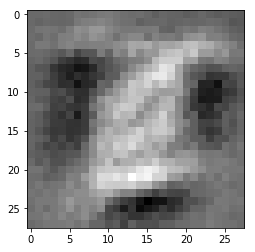

Epoch 1/2... Discriminator Loss: 1.4979... Generator Loss: 0.8028
Epoch 1/2... Discriminator Loss: 1.4582... Generator Loss: 0.7570
Epoch 1/2... Discriminator Loss: 1.4830... Generator Loss: 0.8637
Epoch 1/2... Discriminator Loss: 1.5078... Generator Loss: 0.6236
Epoch 1/2... Discriminator Loss: 1.6717... Generator Loss: 0.3680
Epoch 1/2... Discriminator Loss: 1.7405... Generator Loss: 0.3527
Epoch 1/2... Discriminator Loss: 1.5810... Generator Loss: 0.4201
Epoch 1/2... Discriminator Loss: 1.6138... Generator Loss: 0.4250
Epoch 1/2... Discriminator Loss: 1.4501... Generator Loss: 0.7870
Epoch 1/2... Discriminator Loss: 1.5713... Generator Loss: 0.9373


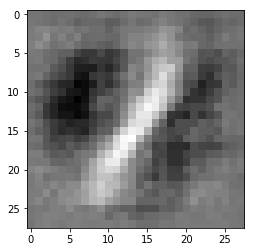

Epoch 1/2... Discriminator Loss: 1.4984... Generator Loss: 0.6794
Epoch 1/2... Discriminator Loss: 1.4645... Generator Loss: 0.9810
Epoch 1/2... Discriminator Loss: 1.4071... Generator Loss: 0.7481
Epoch 1/2... Discriminator Loss: 1.4509... Generator Loss: 0.9066
Epoch 1/2... Discriminator Loss: 1.4478... Generator Loss: 0.7387
Epoch 1/2... Discriminator Loss: 1.5948... Generator Loss: 1.2063
Epoch 1/2... Discriminator Loss: 1.4437... Generator Loss: 0.6049
Epoch 1/2... Discriminator Loss: 1.5059... Generator Loss: 0.9207
Epoch 1/2... Discriminator Loss: 1.5559... Generator Loss: 0.8984
Epoch 1/2... Discriminator Loss: 1.4837... Generator Loss: 0.9380


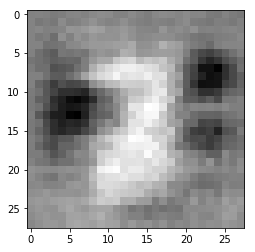

Epoch 1/2... Discriminator Loss: 1.4822... Generator Loss: 0.7623
Epoch 1/2... Discriminator Loss: 1.4397... Generator Loss: 0.5936
Epoch 1/2... Discriminator Loss: 1.7340... Generator Loss: 0.3219
Epoch 1/2... Discriminator Loss: 1.5262... Generator Loss: 0.4690
Epoch 1/2... Discriminator Loss: 1.7965... Generator Loss: 0.2975
Epoch 1/2... Discriminator Loss: 1.5219... Generator Loss: 0.5107
Epoch 1/2... Discriminator Loss: 1.7762... Generator Loss: 0.3119
Epoch 1/2... Discriminator Loss: 1.4792... Generator Loss: 0.5129
Epoch 1/2... Discriminator Loss: 1.6946... Generator Loss: 0.3549
Epoch 1/2... Discriminator Loss: 1.6174... Generator Loss: 0.4051


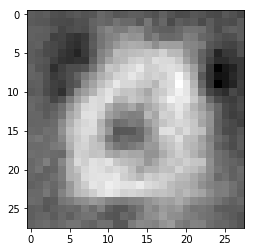

Epoch 1/2... Discriminator Loss: 1.5029... Generator Loss: 0.4955
Epoch 1/2... Discriminator Loss: 1.3823... Generator Loss: 0.6352
Epoch 1/2... Discriminator Loss: 1.4588... Generator Loss: 0.7460
Epoch 1/2... Discriminator Loss: 1.4941... Generator Loss: 0.7145
Epoch 1/2... Discriminator Loss: 1.4399... Generator Loss: 0.5588
Epoch 1/2... Discriminator Loss: 1.5952... Generator Loss: 0.4025
Epoch 1/2... Discriminator Loss: 1.3889... Generator Loss: 0.5795
Epoch 1/2... Discriminator Loss: 1.5484... Generator Loss: 0.4811
Epoch 1/2... Discriminator Loss: 1.9359... Generator Loss: 0.2600
Epoch 1/2... Discriminator Loss: 1.4086... Generator Loss: 0.5971


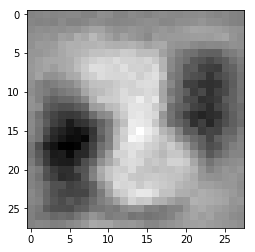

Epoch 1/2... Discriminator Loss: 1.5300... Generator Loss: 0.4451
Epoch 1/2... Discriminator Loss: 1.5807... Generator Loss: 0.3989
Epoch 1/2... Discriminator Loss: 1.3851... Generator Loss: 0.7090
Epoch 1/2... Discriminator Loss: 1.4617... Generator Loss: 0.5131
Epoch 1/2... Discriminator Loss: 1.6613... Generator Loss: 0.3699
Epoch 1/2... Discriminator Loss: 1.3929... Generator Loss: 0.6591
Epoch 1/2... Discriminator Loss: 1.4085... Generator Loss: 0.7421
Epoch 1/2... Discriminator Loss: 1.5866... Generator Loss: 1.1084
Epoch 1/2... Discriminator Loss: 1.4825... Generator Loss: 0.5546
Epoch 1/2... Discriminator Loss: 1.6458... Generator Loss: 0.3527


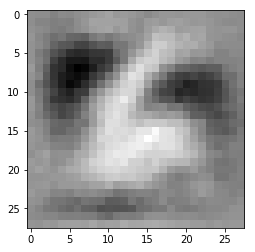

Epoch 1/2... Discriminator Loss: 1.5483... Generator Loss: 0.4662
Epoch 1/2... Discriminator Loss: 1.5968... Generator Loss: 0.3990
Epoch 1/2... Discriminator Loss: 1.4677... Generator Loss: 0.5138
Epoch 2/2... Discriminator Loss: 1.4135... Generator Loss: 0.8313
Epoch 2/2... Discriminator Loss: 1.4323... Generator Loss: 0.6668
Epoch 2/2... Discriminator Loss: 1.6034... Generator Loss: 1.0231
Epoch 2/2... Discriminator Loss: 1.3498... Generator Loss: 0.9667
Epoch 2/2... Discriminator Loss: 1.4570... Generator Loss: 0.5249
Epoch 2/2... Discriminator Loss: 1.5521... Generator Loss: 0.4159
Epoch 2/2... Discriminator Loss: 1.6795... Generator Loss: 0.3779
Epoch 2/2... Discriminator Loss: 1.3724... Generator Loss: 0.6296
Epoch 2/2... Discriminator Loss: 1.5411... Generator Loss: 1.0031
Epoch 2/2... Discriminator Loss: 1.4495... Generator Loss: 0.8278


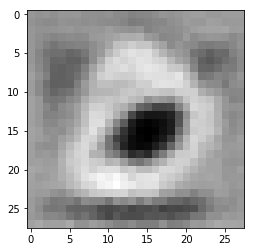

Epoch 2/2... Discriminator Loss: 1.4625... Generator Loss: 0.4768
Epoch 2/2... Discriminator Loss: 1.6240... Generator Loss: 0.3902
Epoch 2/2... Discriminator Loss: 1.6719... Generator Loss: 0.3932
Epoch 2/2... Discriminator Loss: 1.4368... Generator Loss: 0.6437
Epoch 2/2... Discriminator Loss: 1.4461... Generator Loss: 0.5894
Epoch 2/2... Discriminator Loss: 1.8796... Generator Loss: 0.2608
Epoch 2/2... Discriminator Loss: 1.5953... Generator Loss: 0.4171
Epoch 2/2... Discriminator Loss: 1.4378... Generator Loss: 0.8374
Epoch 2/2... Discriminator Loss: 1.4389... Generator Loss: 1.1430
Epoch 2/2... Discriminator Loss: 1.4366... Generator Loss: 0.6824


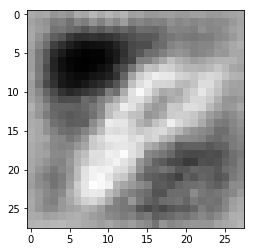

Epoch 2/2... Discriminator Loss: 1.6325... Generator Loss: 0.3630
Epoch 2/2... Discriminator Loss: 1.4769... Generator Loss: 0.5159
Epoch 2/2... Discriminator Loss: 1.7270... Generator Loss: 0.3183
Epoch 2/2... Discriminator Loss: 1.5240... Generator Loss: 0.4138


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 1.1029... Generator Loss: 20.1501
Epoch 1/2... Discriminator Loss: 2.3626... Generator Loss: 0.4242
Epoch 1/2... Discriminator Loss: 1.7673... Generator Loss: 0.5063
Epoch 1/2... Discriminator Loss: 2.5676... Generator Loss: 0.1433
Epoch 1/2... Discriminator Loss: 2.5040... Generator Loss: 0.1439
Epoch 1/2... Discriminator Loss: 1.2456... Generator Loss: 0.6324
Epoch 1/2... Discriminator Loss: 1.0389... Generator Loss: 1.3333
Epoch 1/2... Discriminator Loss: 2.2958... Generator Loss: 0.2012
Epoch 1/2... Discriminator Loss: 1.3662... Generator Loss: 1.1155
Epoch 1/2... Discriminator Loss: 1.5717... Generator Loss: 0.9192


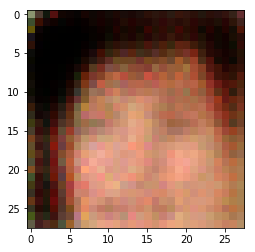

Epoch 1/2... Discriminator Loss: 1.6710... Generator Loss: 0.6802
Epoch 1/2... Discriminator Loss: 1.6619... Generator Loss: 0.5499
Epoch 1/2... Discriminator Loss: 1.5379... Generator Loss: 0.7693
Epoch 1/2... Discriminator Loss: 1.5488... Generator Loss: 0.6519
Epoch 1/2... Discriminator Loss: 1.5233... Generator Loss: 0.7744
Epoch 1/2... Discriminator Loss: 1.5239... Generator Loss: 0.7300
Epoch 1/2... Discriminator Loss: 1.4730... Generator Loss: 0.7832
Epoch 1/2... Discriminator Loss: 1.5183... Generator Loss: 0.7657
Epoch 1/2... Discriminator Loss: 1.4652... Generator Loss: 0.7299
Epoch 1/2... Discriminator Loss: 1.5274... Generator Loss: 0.6308


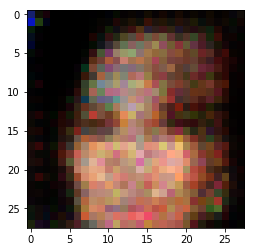

Epoch 1/2... Discriminator Loss: 1.4823... Generator Loss: 0.7897
Epoch 1/2... Discriminator Loss: 1.5697... Generator Loss: 0.7141
Epoch 1/2... Discriminator Loss: 1.4106... Generator Loss: 0.7639
Epoch 1/2... Discriminator Loss: 1.5167... Generator Loss: 0.6164
Epoch 1/2... Discriminator Loss: 1.5930... Generator Loss: 0.7927
Epoch 1/2... Discriminator Loss: 1.5157... Generator Loss: 0.6844
Epoch 1/2... Discriminator Loss: 1.5828... Generator Loss: 0.7177
Epoch 1/2... Discriminator Loss: 1.5835... Generator Loss: 0.6325
Epoch 1/2... Discriminator Loss: 1.4325... Generator Loss: 0.8006
Epoch 1/2... Discriminator Loss: 1.4360... Generator Loss: 0.7397


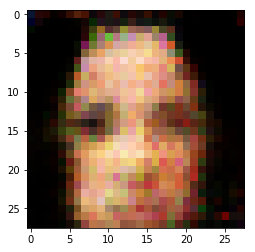

Epoch 1/2... Discriminator Loss: 1.4232... Generator Loss: 0.7463
Epoch 1/2... Discriminator Loss: 1.4296... Generator Loss: 0.9578
Epoch 1/2... Discriminator Loss: 1.4479... Generator Loss: 0.7133
Epoch 1/2... Discriminator Loss: 1.4226... Generator Loss: 0.7567
Epoch 1/2... Discriminator Loss: 1.4262... Generator Loss: 0.7901
Epoch 1/2... Discriminator Loss: 1.4147... Generator Loss: 0.6492
Epoch 1/2... Discriminator Loss: 1.5600... Generator Loss: 0.9489
Epoch 1/2... Discriminator Loss: 1.4237... Generator Loss: 1.3071
Epoch 1/2... Discriminator Loss: 1.4384... Generator Loss: 0.6961
Epoch 1/2... Discriminator Loss: 1.4942... Generator Loss: 0.5988


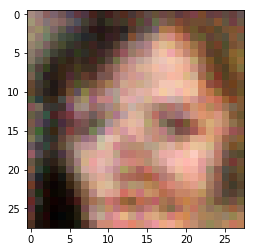

Epoch 1/2... Discriminator Loss: 1.4518... Generator Loss: 0.6453
Epoch 1/2... Discriminator Loss: 1.5288... Generator Loss: 0.5457
Epoch 1/2... Discriminator Loss: 1.4650... Generator Loss: 0.6414
Epoch 1/2... Discriminator Loss: 1.4413... Generator Loss: 0.7569
Epoch 1/2... Discriminator Loss: 1.3763... Generator Loss: 0.8643
Epoch 1/2... Discriminator Loss: 1.4567... Generator Loss: 0.6858
Epoch 1/2... Discriminator Loss: 1.6267... Generator Loss: 0.5608
Epoch 1/2... Discriminator Loss: 1.4812... Generator Loss: 0.6570
Epoch 1/2... Discriminator Loss: 1.4530... Generator Loss: 0.7802
Epoch 1/2... Discriminator Loss: 1.4307... Generator Loss: 0.8233


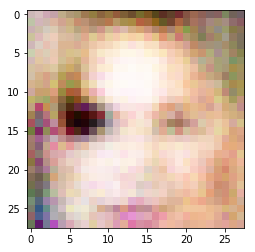

Epoch 1/2... Discriminator Loss: 1.4621... Generator Loss: 0.6785
Epoch 1/2... Discriminator Loss: 1.4490... Generator Loss: 0.8253
Epoch 1/2... Discriminator Loss: 1.4130... Generator Loss: 0.7712
Epoch 1/2... Discriminator Loss: 1.5830... Generator Loss: 0.4349
Epoch 1/2... Discriminator Loss: 1.3724... Generator Loss: 0.9466
Epoch 1/2... Discriminator Loss: 1.4645... Generator Loss: 0.8638
Epoch 1/2... Discriminator Loss: 1.5107... Generator Loss: 0.6228
Epoch 1/2... Discriminator Loss: 1.4686... Generator Loss: 0.7023
Epoch 1/2... Discriminator Loss: 1.5811... Generator Loss: 0.5027
Epoch 1/2... Discriminator Loss: 1.3780... Generator Loss: 0.7255


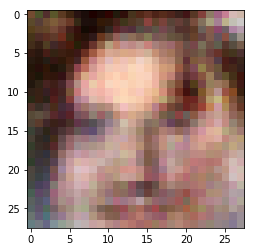

Epoch 1/2... Discriminator Loss: 1.3683... Generator Loss: 0.9532
Epoch 1/2... Discriminator Loss: 1.4292... Generator Loss: 0.8670
Epoch 1/2... Discriminator Loss: 1.4209... Generator Loss: 0.6920
Epoch 1/2... Discriminator Loss: 1.4915... Generator Loss: 0.7167
Epoch 1/2... Discriminator Loss: 1.4003... Generator Loss: 0.6594
Epoch 1/2... Discriminator Loss: 1.6078... Generator Loss: 0.4552
Epoch 1/2... Discriminator Loss: 1.5556... Generator Loss: 0.5289
Epoch 1/2... Discriminator Loss: 1.4547... Generator Loss: 0.8457
Epoch 1/2... Discriminator Loss: 1.3616... Generator Loss: 0.8166
Epoch 1/2... Discriminator Loss: 1.5035... Generator Loss: 0.7003


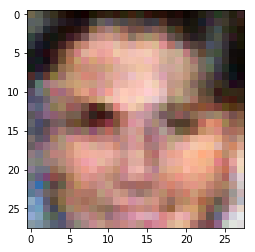

Epoch 1/2... Discriminator Loss: 1.5944... Generator Loss: 0.4529
Epoch 1/2... Discriminator Loss: 1.2820... Generator Loss: 0.8105
Epoch 1/2... Discriminator Loss: 1.5823... Generator Loss: 0.5203
Epoch 1/2... Discriminator Loss: 1.4064... Generator Loss: 0.8051
Epoch 1/2... Discriminator Loss: 1.4689... Generator Loss: 0.7000
Epoch 1/2... Discriminator Loss: 1.4641... Generator Loss: 0.7441
Epoch 1/2... Discriminator Loss: 1.6053... Generator Loss: 0.5929
Epoch 1/2... Discriminator Loss: 1.5961... Generator Loss: 0.6804
Epoch 1/2... Discriminator Loss: 1.4240... Generator Loss: 0.7850
Epoch 1/2... Discriminator Loss: 1.4580... Generator Loss: 0.8142


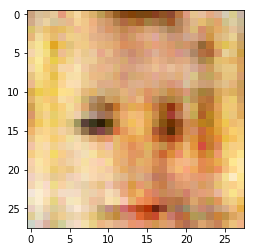

Epoch 1/2... Discriminator Loss: 1.5036... Generator Loss: 0.6270
Epoch 1/2... Discriminator Loss: 1.4092... Generator Loss: 0.7606
Epoch 1/2... Discriminator Loss: 1.4511... Generator Loss: 0.8853
Epoch 1/2... Discriminator Loss: 1.4514... Generator Loss: 0.7570
Epoch 1/2... Discriminator Loss: 1.5501... Generator Loss: 0.5631
Epoch 1/2... Discriminator Loss: 1.6031... Generator Loss: 0.9257
Epoch 1/2... Discriminator Loss: 1.4729... Generator Loss: 0.7567
Epoch 1/2... Discriminator Loss: 1.4692... Generator Loss: 0.7709
Epoch 1/2... Discriminator Loss: 1.4126... Generator Loss: 0.7016
Epoch 1/2... Discriminator Loss: 1.5107... Generator Loss: 0.6114


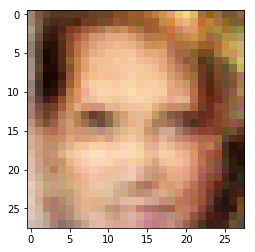

Epoch 1/2... Discriminator Loss: 1.4775... Generator Loss: 0.8289
Epoch 1/2... Discriminator Loss: 1.4060... Generator Loss: 0.8350
Epoch 1/2... Discriminator Loss: 1.5018... Generator Loss: 0.9011
Epoch 1/2... Discriminator Loss: 1.4533... Generator Loss: 0.6302
Epoch 1/2... Discriminator Loss: 1.4487... Generator Loss: 0.8394
Epoch 1/2... Discriminator Loss: 1.4307... Generator Loss: 0.6968
Epoch 1/2... Discriminator Loss: 1.4212... Generator Loss: 0.8601
Epoch 1/2... Discriminator Loss: 1.4255... Generator Loss: 0.6626
Epoch 1/2... Discriminator Loss: 1.4468... Generator Loss: 0.6077
Epoch 1/2... Discriminator Loss: 1.4824... Generator Loss: 0.6219


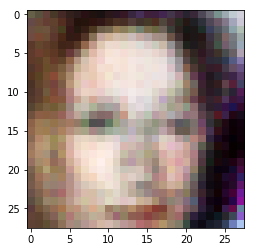

Epoch 1/2... Discriminator Loss: 1.4639... Generator Loss: 0.6226
Epoch 1/2... Discriminator Loss: 1.4770... Generator Loss: 0.6639
Epoch 1/2... Discriminator Loss: 1.4360... Generator Loss: 0.7582
Epoch 1/2... Discriminator Loss: 1.4117... Generator Loss: 0.7336
Epoch 1/2... Discriminator Loss: 1.4119... Generator Loss: 0.7376
Epoch 1/2... Discriminator Loss: 1.5344... Generator Loss: 0.6133
Epoch 1/2... Discriminator Loss: 1.5384... Generator Loss: 0.6237
Epoch 1/2... Discriminator Loss: 1.4506... Generator Loss: 0.7421
Epoch 1/2... Discriminator Loss: 1.4314... Generator Loss: 0.6819
Epoch 1/2... Discriminator Loss: 1.4483... Generator Loss: 0.7063


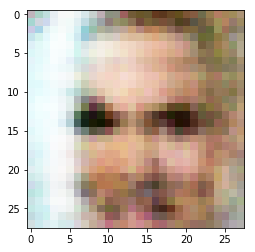

Epoch 1/2... Discriminator Loss: 1.4140... Generator Loss: 0.6552
Epoch 1/2... Discriminator Loss: 1.4220... Generator Loss: 0.8528
Epoch 1/2... Discriminator Loss: 1.4663... Generator Loss: 0.6592
Epoch 1/2... Discriminator Loss: 1.4695... Generator Loss: 0.8092
Epoch 1/2... Discriminator Loss: 1.4295... Generator Loss: 0.6484
Epoch 1/2... Discriminator Loss: 1.6157... Generator Loss: 0.5827
Epoch 1/2... Discriminator Loss: 1.4253... Generator Loss: 0.6695
Epoch 1/2... Discriminator Loss: 1.5117... Generator Loss: 0.8383
Epoch 1/2... Discriminator Loss: 1.4553... Generator Loss: 0.7602
Epoch 1/2... Discriminator Loss: 1.4667... Generator Loss: 0.9126


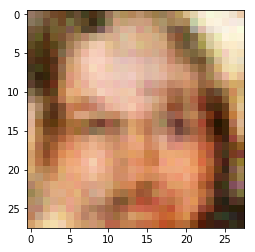

Epoch 1/2... Discriminator Loss: 1.4258... Generator Loss: 0.8249
Epoch 1/2... Discriminator Loss: 1.5355... Generator Loss: 0.9490
Epoch 1/2... Discriminator Loss: 1.4619... Generator Loss: 0.7668
Epoch 1/2... Discriminator Loss: 1.4924... Generator Loss: 0.6905
Epoch 1/2... Discriminator Loss: 1.4243... Generator Loss: 0.7525
Epoch 1/2... Discriminator Loss: 1.3933... Generator Loss: 0.6844
Epoch 1/2... Discriminator Loss: 1.4683... Generator Loss: 0.6064
Epoch 1/2... Discriminator Loss: 1.4782... Generator Loss: 0.6226
Epoch 1/2... Discriminator Loss: 1.4491... Generator Loss: 0.5862
Epoch 1/2... Discriminator Loss: 1.4565... Generator Loss: 0.7012


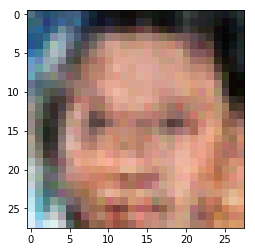

Epoch 1/2... Discriminator Loss: 1.4255... Generator Loss: 0.7021
Epoch 1/2... Discriminator Loss: 1.4550... Generator Loss: 0.7007
Epoch 1/2... Discriminator Loss: 1.4738... Generator Loss: 0.6827
Epoch 1/2... Discriminator Loss: 1.3956... Generator Loss: 0.7949
Epoch 1/2... Discriminator Loss: 1.4442... Generator Loss: 0.7557
Epoch 1/2... Discriminator Loss: 1.4886... Generator Loss: 0.8255
Epoch 1/2... Discriminator Loss: 1.4290... Generator Loss: 0.6557
Epoch 1/2... Discriminator Loss: 1.4252... Generator Loss: 0.7796
Epoch 1/2... Discriminator Loss: 1.4424... Generator Loss: 0.7666
Epoch 1/2... Discriminator Loss: 1.4205... Generator Loss: 0.7282


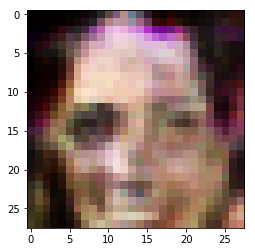

Epoch 1/2... Discriminator Loss: 1.3981... Generator Loss: 0.8414
Epoch 1/2... Discriminator Loss: 1.4630... Generator Loss: 0.7519
Epoch 1/2... Discriminator Loss: 1.4275... Generator Loss: 0.6530
Epoch 1/2... Discriminator Loss: 1.4132... Generator Loss: 0.7667
Epoch 1/2... Discriminator Loss: 1.3153... Generator Loss: 0.7918
Epoch 1/2... Discriminator Loss: 1.4281... Generator Loss: 0.7509
Epoch 1/2... Discriminator Loss: 1.3757... Generator Loss: 0.7689
Epoch 1/2... Discriminator Loss: 1.4620... Generator Loss: 0.7702
Epoch 1/2... Discriminator Loss: 1.4317... Generator Loss: 0.8123
Epoch 1/2... Discriminator Loss: 1.4512... Generator Loss: 0.8019


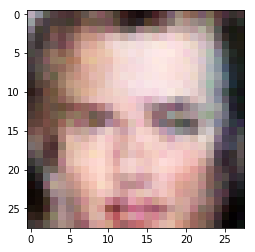

Epoch 1/2... Discriminator Loss: 1.4801... Generator Loss: 0.7896
Epoch 1/2... Discriminator Loss: 1.4555... Generator Loss: 0.7237
Epoch 1/2... Discriminator Loss: 1.4926... Generator Loss: 0.7018
Epoch 1/2... Discriminator Loss: 1.4504... Generator Loss: 0.7197
Epoch 1/2... Discriminator Loss: 1.4161... Generator Loss: 0.7331
Epoch 1/2... Discriminator Loss: 1.4212... Generator Loss: 0.7629
Epoch 1/2... Discriminator Loss: 1.4341... Generator Loss: 0.8059
Epoch 1/2... Discriminator Loss: 1.4287... Generator Loss: 0.7843
Epoch 1/2... Discriminator Loss: 1.4687... Generator Loss: 0.8099
Epoch 1/2... Discriminator Loss: 1.5248... Generator Loss: 0.7524


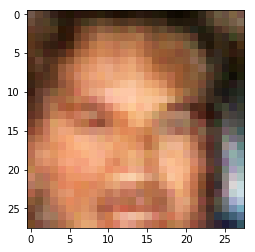

Epoch 1/2... Discriminator Loss: 1.4512... Generator Loss: 0.8350
Epoch 1/2... Discriminator Loss: 1.4643... Generator Loss: 0.8346
Epoch 1/2... Discriminator Loss: 1.4542... Generator Loss: 0.8033
Epoch 1/2... Discriminator Loss: 1.3273... Generator Loss: 0.8134
Epoch 1/2... Discriminator Loss: 1.4680... Generator Loss: 0.7279
Epoch 1/2... Discriminator Loss: 1.4008... Generator Loss: 0.7856
Epoch 1/2... Discriminator Loss: 1.4456... Generator Loss: 0.8965
Epoch 1/2... Discriminator Loss: 1.4369... Generator Loss: 0.7531
Epoch 1/2... Discriminator Loss: 1.4145... Generator Loss: 0.8108
Epoch 1/2... Discriminator Loss: 1.4541... Generator Loss: 0.7086


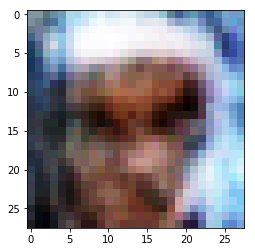

Epoch 1/2... Discriminator Loss: 1.4772... Generator Loss: 0.5900
Epoch 1/2... Discriminator Loss: 1.4735... Generator Loss: 0.6290
Epoch 1/2... Discriminator Loss: 1.4182... Generator Loss: 0.7761
Epoch 1/2... Discriminator Loss: 1.4640... Generator Loss: 0.7805
Epoch 1/2... Discriminator Loss: 1.5218... Generator Loss: 0.7127
Epoch 1/2... Discriminator Loss: 1.3829... Generator Loss: 0.8176
Epoch 1/2... Discriminator Loss: 1.4362... Generator Loss: 0.6953
Epoch 1/2... Discriminator Loss: 1.4192... Generator Loss: 0.7753
Epoch 1/2... Discriminator Loss: 1.3908... Generator Loss: 0.7200
Epoch 1/2... Discriminator Loss: 1.5158... Generator Loss: 0.7299


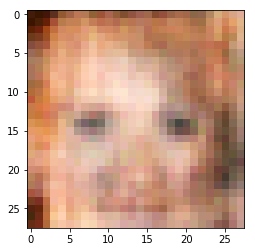

Epoch 1/2... Discriminator Loss: 1.4058... Generator Loss: 0.6985
Epoch 1/2... Discriminator Loss: 1.4675... Generator Loss: 0.6544
Epoch 1/2... Discriminator Loss: 1.3928... Generator Loss: 0.7927
Epoch 1/2... Discriminator Loss: 1.3771... Generator Loss: 0.8412
Epoch 1/2... Discriminator Loss: 1.4160... Generator Loss: 0.7837
Epoch 1/2... Discriminator Loss: 1.4180... Generator Loss: 0.7508
Epoch 1/2... Discriminator Loss: 1.3851... Generator Loss: 0.7734
Epoch 1/2... Discriminator Loss: 1.4503... Generator Loss: 0.7465
Epoch 1/2... Discriminator Loss: 1.3992... Generator Loss: 0.7481
Epoch 1/2... Discriminator Loss: 1.4142... Generator Loss: 0.7232


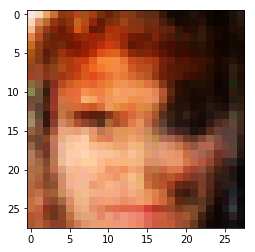

Epoch 1/2... Discriminator Loss: 1.5446... Generator Loss: 0.6889
Epoch 1/2... Discriminator Loss: 1.4962... Generator Loss: 0.7228
Epoch 1/2... Discriminator Loss: 1.4074... Generator Loss: 0.8268
Epoch 1/2... Discriminator Loss: 1.4120... Generator Loss: 0.7425
Epoch 1/2... Discriminator Loss: 1.4433... Generator Loss: 0.7697
Epoch 1/2... Discriminator Loss: 1.4242... Generator Loss: 0.8115
Epoch 1/2... Discriminator Loss: 1.4399... Generator Loss: 0.8771
Epoch 1/2... Discriminator Loss: 1.4509... Generator Loss: 0.6753
Epoch 1/2... Discriminator Loss: 1.4419... Generator Loss: 0.7133
Epoch 1/2... Discriminator Loss: 1.4518... Generator Loss: 0.7567


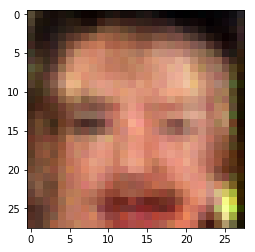

Epoch 1/2... Discriminator Loss: 1.4238... Generator Loss: 0.7887
Epoch 1/2... Discriminator Loss: 1.4335... Generator Loss: 0.8398
Epoch 1/2... Discriminator Loss: 1.4062... Generator Loss: 0.8188
Epoch 1/2... Discriminator Loss: 1.4068... Generator Loss: 0.7953
Epoch 1/2... Discriminator Loss: 1.4355... Generator Loss: 0.7756
Epoch 1/2... Discriminator Loss: 1.3811... Generator Loss: 0.8135
Epoch 1/2... Discriminator Loss: 1.4282... Generator Loss: 0.7783
Epoch 1/2... Discriminator Loss: 1.4412... Generator Loss: 0.8358
Epoch 1/2... Discriminator Loss: 1.4097... Generator Loss: 0.7971
Epoch 1/2... Discriminator Loss: 1.5113... Generator Loss: 0.6849


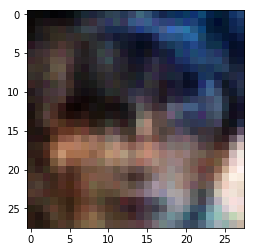

Epoch 1/2... Discriminator Loss: 1.5137... Generator Loss: 0.7296
Epoch 1/2... Discriminator Loss: 1.5753... Generator Loss: 0.6046
Epoch 1/2... Discriminator Loss: 1.3964... Generator Loss: 0.7218
Epoch 1/2... Discriminator Loss: 1.4253... Generator Loss: 0.8540
Epoch 1/2... Discriminator Loss: 1.4389... Generator Loss: 0.8047
Epoch 1/2... Discriminator Loss: 1.4080... Generator Loss: 0.7544
Epoch 1/2... Discriminator Loss: 1.4331... Generator Loss: 0.7364
Epoch 1/2... Discriminator Loss: 1.4308... Generator Loss: 0.7205
Epoch 1/2... Discriminator Loss: 1.4168... Generator Loss: 0.7612
Epoch 1/2... Discriminator Loss: 1.4309... Generator Loss: 0.7105


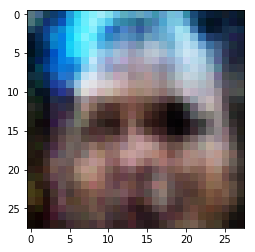

Epoch 1/2... Discriminator Loss: 1.4325... Generator Loss: 0.7183
Epoch 1/2... Discriminator Loss: 1.4415... Generator Loss: 0.7726
Epoch 1/2... Discriminator Loss: 1.4360... Generator Loss: 0.6810
Epoch 1/2... Discriminator Loss: 1.3979... Generator Loss: 0.7510
Epoch 1/2... Discriminator Loss: 1.4214... Generator Loss: 0.7171
Epoch 1/2... Discriminator Loss: 1.4156... Generator Loss: 0.7640
Epoch 1/2... Discriminator Loss: 1.3955... Generator Loss: 0.7867
Epoch 1/2... Discriminator Loss: 1.4217... Generator Loss: 0.7295
Epoch 1/2... Discriminator Loss: 1.4367... Generator Loss: 0.7994
Epoch 1/2... Discriminator Loss: 1.4542... Generator Loss: 0.7954


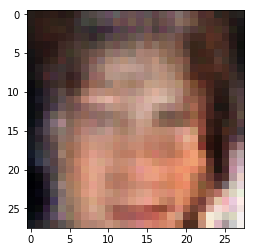

Epoch 1/2... Discriminator Loss: 1.4570... Generator Loss: 0.7835
Epoch 1/2... Discriminator Loss: 1.4124... Generator Loss: 0.8531
Epoch 1/2... Discriminator Loss: 1.4253... Generator Loss: 0.7008
Epoch 1/2... Discriminator Loss: 1.4000... Generator Loss: 0.7577
Epoch 1/2... Discriminator Loss: 1.4120... Generator Loss: 0.7954
Epoch 1/2... Discriminator Loss: 1.3945... Generator Loss: 0.7284
Epoch 1/2... Discriminator Loss: 1.4660... Generator Loss: 0.6978
Epoch 1/2... Discriminator Loss: 1.4341... Generator Loss: 0.7019
Epoch 1/2... Discriminator Loss: 1.4513... Generator Loss: 0.6214
Epoch 1/2... Discriminator Loss: 1.4149... Generator Loss: 0.8230


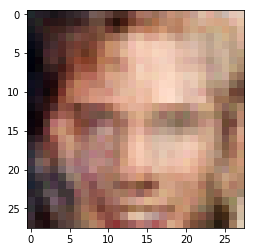

Epoch 1/2... Discriminator Loss: 1.4413... Generator Loss: 0.7180
Epoch 1/2... Discriminator Loss: 1.4044... Generator Loss: 0.7617
Epoch 1/2... Discriminator Loss: 1.4641... Generator Loss: 0.7947
Epoch 1/2... Discriminator Loss: 1.3908... Generator Loss: 0.7580
Epoch 1/2... Discriminator Loss: 1.3997... Generator Loss: 0.7685
Epoch 1/2... Discriminator Loss: 1.4159... Generator Loss: 0.7769
Epoch 1/2... Discriminator Loss: 1.4314... Generator Loss: 0.8134
Epoch 1/2... Discriminator Loss: 1.4483... Generator Loss: 0.7260
Epoch 1/2... Discriminator Loss: 1.4393... Generator Loss: 0.8532
Epoch 1/2... Discriminator Loss: 1.4108... Generator Loss: 0.7849


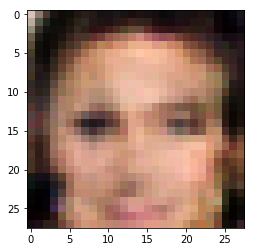

Epoch 1/2... Discriminator Loss: 1.4326... Generator Loss: 0.7349
Epoch 1/2... Discriminator Loss: 1.4005... Generator Loss: 0.7466
Epoch 1/2... Discriminator Loss: 1.4772... Generator Loss: 0.7398
Epoch 1/2... Discriminator Loss: 1.4284... Generator Loss: 0.7767
Epoch 1/2... Discriminator Loss: 1.4238... Generator Loss: 0.8262
Epoch 1/2... Discriminator Loss: 1.4045... Generator Loss: 0.8239
Epoch 1/2... Discriminator Loss: 1.4673... Generator Loss: 0.7704
Epoch 1/2... Discriminator Loss: 1.4624... Generator Loss: 0.7668
Epoch 1/2... Discriminator Loss: 1.4189... Generator Loss: 0.7405
Epoch 1/2... Discriminator Loss: 1.3955... Generator Loss: 0.7686


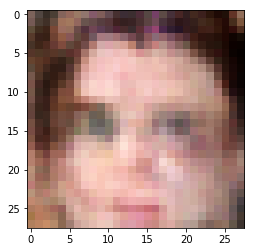

Epoch 1/2... Discriminator Loss: 1.4315... Generator Loss: 0.7354
Epoch 1/2... Discriminator Loss: 1.3864... Generator Loss: 0.8428
Epoch 1/2... Discriminator Loss: 1.4111... Generator Loss: 0.7859
Epoch 1/2... Discriminator Loss: 1.4798... Generator Loss: 0.6565
Epoch 1/2... Discriminator Loss: 1.3791... Generator Loss: 0.9217
Epoch 1/2... Discriminator Loss: 1.4164... Generator Loss: 0.8384
Epoch 1/2... Discriminator Loss: 1.4316... Generator Loss: 0.6934
Epoch 1/2... Discriminator Loss: 1.4303... Generator Loss: 0.8426
Epoch 1/2... Discriminator Loss: 1.3927... Generator Loss: 0.7311
Epoch 1/2... Discriminator Loss: 1.4088... Generator Loss: 0.7538


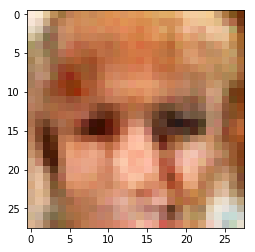

Epoch 1/2... Discriminator Loss: 1.4328... Generator Loss: 0.8231
Epoch 1/2... Discriminator Loss: 1.4103... Generator Loss: 0.6797
Epoch 1/2... Discriminator Loss: 1.3972... Generator Loss: 0.8285
Epoch 1/2... Discriminator Loss: 1.3913... Generator Loss: 0.7218
Epoch 1/2... Discriminator Loss: 1.4137... Generator Loss: 0.8208
Epoch 1/2... Discriminator Loss: 1.5021... Generator Loss: 0.6003
Epoch 1/2... Discriminator Loss: 1.4284... Generator Loss: 0.8704
Epoch 1/2... Discriminator Loss: 1.4069... Generator Loss: 0.8259
Epoch 1/2... Discriminator Loss: 1.4458... Generator Loss: 0.6914
Epoch 1/2... Discriminator Loss: 1.4427... Generator Loss: 0.8123


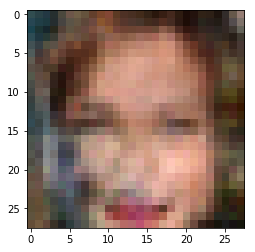

Epoch 1/2... Discriminator Loss: 1.4163... Generator Loss: 0.6882
Epoch 1/2... Discriminator Loss: 1.4451... Generator Loss: 0.8221
Epoch 1/2... Discriminator Loss: 1.4077... Generator Loss: 0.7625
Epoch 1/2... Discriminator Loss: 1.5105... Generator Loss: 0.7701
Epoch 1/2... Discriminator Loss: 1.3968... Generator Loss: 0.7709
Epoch 1/2... Discriminator Loss: 1.4034... Generator Loss: 0.7576
Epoch 1/2... Discriminator Loss: 1.4240... Generator Loss: 0.7347
Epoch 1/2... Discriminator Loss: 1.4342... Generator Loss: 0.7914
Epoch 1/2... Discriminator Loss: 1.4101... Generator Loss: 0.7165
Epoch 1/2... Discriminator Loss: 1.3900... Generator Loss: 0.7396


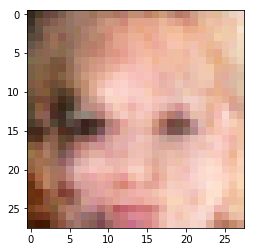

Epoch 1/2... Discriminator Loss: 1.3932... Generator Loss: 0.8221
Epoch 1/2... Discriminator Loss: 1.3748... Generator Loss: 0.7463
Epoch 1/2... Discriminator Loss: 1.4083... Generator Loss: 0.7850
Epoch 1/2... Discriminator Loss: 1.4455... Generator Loss: 0.7118
Epoch 1/2... Discriminator Loss: 1.4362... Generator Loss: 0.7269
Epoch 1/2... Discriminator Loss: 1.3959... Generator Loss: 0.7314
Epoch 1/2... Discriminator Loss: 1.4096... Generator Loss: 0.7130
Epoch 1/2... Discriminator Loss: 1.3915... Generator Loss: 0.8408
Epoch 1/2... Discriminator Loss: 1.4395... Generator Loss: 0.7057
Epoch 1/2... Discriminator Loss: 1.4419... Generator Loss: 0.7358


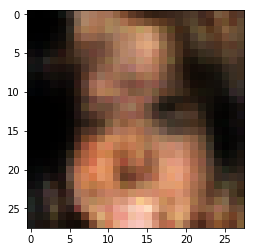

Epoch 1/2... Discriminator Loss: 1.4047... Generator Loss: 0.7900
Epoch 1/2... Discriminator Loss: 1.4118... Generator Loss: 0.7690
Epoch 1/2... Discriminator Loss: 1.4018... Generator Loss: 0.7684
Epoch 1/2... Discriminator Loss: 1.3972... Generator Loss: 0.7506
Epoch 1/2... Discriminator Loss: 1.4135... Generator Loss: 0.7880
Epoch 1/2... Discriminator Loss: 1.4262... Generator Loss: 0.7534
Epoch 1/2... Discriminator Loss: 1.4018... Generator Loss: 0.7177
Epoch 1/2... Discriminator Loss: 1.4117... Generator Loss: 0.7415
Epoch 1/2... Discriminator Loss: 1.4244... Generator Loss: 0.7952
Epoch 1/2... Discriminator Loss: 1.4349... Generator Loss: 0.8379


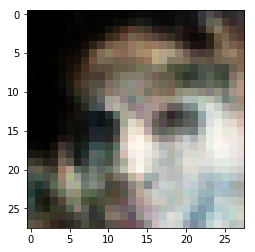

Epoch 1/2... Discriminator Loss: 1.4019... Generator Loss: 0.8179
Epoch 1/2... Discriminator Loss: 1.3812... Generator Loss: 0.8414
Epoch 1/2... Discriminator Loss: 1.4372... Generator Loss: 0.6705
Epoch 1/2... Discriminator Loss: 1.4107... Generator Loss: 0.7920
Epoch 1/2... Discriminator Loss: 1.4375... Generator Loss: 0.7065
Epoch 1/2... Discriminator Loss: 1.4230... Generator Loss: 0.7112
Epoch 2/2... Discriminator Loss: 1.4147... Generator Loss: 0.8177
Epoch 2/2... Discriminator Loss: 1.4122... Generator Loss: 0.7601
Epoch 2/2... Discriminator Loss: 1.4458... Generator Loss: 0.6945
Epoch 2/2... Discriminator Loss: 1.4096... Generator Loss: 0.6073
Epoch 2/2... Discriminator Loss: 1.4606... Generator Loss: 0.7689
Epoch 2/2... Discriminator Loss: 1.4232... Generator Loss: 0.8477
Epoch 2/2... Discriminator Loss: 1.4074... Generator Loss: 0.7377
Epoch 2/2... Discriminator Loss: 1.4387... Generator Loss: 0.7447
Epoch 2/2... Discriminator Loss: 1.4057... Generator Loss: 0.8253
Epoch 2/2.

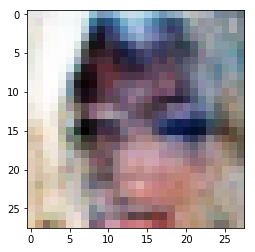

Epoch 2/2... Discriminator Loss: 1.4355... Generator Loss: 0.7654
Epoch 2/2... Discriminator Loss: 1.4262... Generator Loss: 0.6673
Epoch 2/2... Discriminator Loss: 1.4034... Generator Loss: 0.7619
Epoch 2/2... Discriminator Loss: 1.3818... Generator Loss: 0.7768
Epoch 2/2... Discriminator Loss: 1.4421... Generator Loss: 0.8929
Epoch 2/2... Discriminator Loss: 1.4019... Generator Loss: 0.7891
Epoch 2/2... Discriminator Loss: 1.3765... Generator Loss: 0.8754
Epoch 2/2... Discriminator Loss: 1.3839... Generator Loss: 0.8199
Epoch 2/2... Discriminator Loss: 1.4052... Generator Loss: 0.7051
Epoch 2/2... Discriminator Loss: 1.4390... Generator Loss: 0.7775


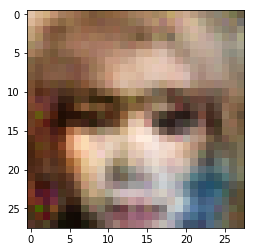

Epoch 2/2... Discriminator Loss: 1.3913... Generator Loss: 0.8609
Epoch 2/2... Discriminator Loss: 1.4076... Generator Loss: 0.7578
Epoch 2/2... Discriminator Loss: 1.4010... Generator Loss: 0.7995
Epoch 2/2... Discriminator Loss: 1.3904... Generator Loss: 0.7614
Epoch 2/2... Discriminator Loss: 1.4025... Generator Loss: 0.7980
Epoch 2/2... Discriminator Loss: 1.4250... Generator Loss: 0.7491
Epoch 2/2... Discriminator Loss: 1.4320... Generator Loss: 0.6885
Epoch 2/2... Discriminator Loss: 1.4126... Generator Loss: 0.7043
Epoch 2/2... Discriminator Loss: 1.4442... Generator Loss: 0.7092
Epoch 2/2... Discriminator Loss: 1.4616... Generator Loss: 0.6718


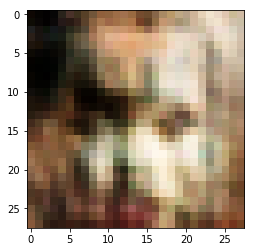

Epoch 2/2... Discriminator Loss: 1.3947... Generator Loss: 0.7105
Epoch 2/2... Discriminator Loss: 1.5268... Generator Loss: 0.6822
Epoch 2/2... Discriminator Loss: 1.4278... Generator Loss: 0.6799
Epoch 2/2... Discriminator Loss: 1.4086... Generator Loss: 0.7477
Epoch 2/2... Discriminator Loss: 1.4205... Generator Loss: 0.8104
Epoch 2/2... Discriminator Loss: 1.4441... Generator Loss: 0.7293
Epoch 2/2... Discriminator Loss: 1.4056... Generator Loss: 0.7657
Epoch 2/2... Discriminator Loss: 1.3881... Generator Loss: 0.7869
Epoch 2/2... Discriminator Loss: 1.4289... Generator Loss: 0.6284
Epoch 2/2... Discriminator Loss: 1.3999... Generator Loss: 0.7927


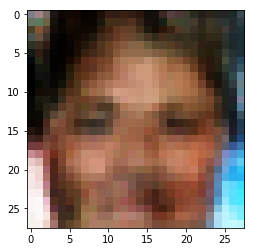

Epoch 2/2... Discriminator Loss: 1.3880... Generator Loss: 0.7190
Epoch 2/2... Discriminator Loss: 1.4327... Generator Loss: 0.6423
Epoch 2/2... Discriminator Loss: 1.4089... Generator Loss: 0.7377
Epoch 2/2... Discriminator Loss: 1.3950... Generator Loss: 0.7946
Epoch 2/2... Discriminator Loss: 1.4033... Generator Loss: 0.8555
Epoch 2/2... Discriminator Loss: 1.3959... Generator Loss: 0.7538
Epoch 2/2... Discriminator Loss: 1.4492... Generator Loss: 0.7681
Epoch 2/2... Discriminator Loss: 1.4249... Generator Loss: 0.7173
Epoch 2/2... Discriminator Loss: 1.4001... Generator Loss: 0.7833


KeyboardInterrupt: 

In [12]:
import os
from glob import glob
from matplotlib import pyplot

batch_size = 64
z_dim = 100
learning_rate = 0.0007
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir+ '/img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.